In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import defaultdict # For easier subject counts
import operator
from tqdm.notebook import tqdm
import datetime
import re
import pickle
import random
# Optional: for better display in Jupyter
from IPython.display import display
from scipy.stats import truncnorm

New method - generates social blocks and allocates. 

In [85]:
df = pd.read_csv('schedules_with_final_budgets2.csv')
total_social_budget = df['SocialBudget'].sum()

# Weekly allocation fractions
week_fracs = [1/3, 2/9, 2/9, 2/9]
weekly_budgets = [total_social_budget * frac for frac in week_fracs]
print("Weekly social budgets:", weekly_budgets)

Weekly social budgets: [np.float64(278091.3333333333), np.float64(185394.22222222222), np.float64(185394.22222222222), np.float64(185394.22222222222)]


In [86]:
def split_budget(budget):
    return [budget * week_fracs[0]] + [budget * week_fracs[1]]*3

df['WeeklySocialBudgets'] = df['SocialBudget'].apply(split_budget)

In [87]:
def generate_blocks(week_budget, mean=5, std=1.0):
    blocks = []
    remaining = week_budget + 10
    while remaining > 0:
        block = int(np.clip(np.random.normal(mean, std), 1, 6))
        if block > remaining:
            block = int(np.ceil(remaining))
        blocks.append(block)
        remaining -= block
    return blocks

# For each student, for each week, generate block lengths
all_blocks = []
for idx, row in df.iterrows():
    student_blocks = []
    for week_budget in row['WeeklySocialBudgets']:
        week_blocks = generate_blocks(week_budget)
        student_blocks.append(week_blocks)
    all_blocks.append(student_blocks)

df['WeeklySocialBlocks'] = all_blocks

In [88]:
# Print the weekly social blocks for a sample student (e.g., first student in df)
sample_idx = 0
if 'WeeklySocialBlocks' in df.columns:
    print(f"Weekly social blocks for student {sample_idx}:")
    print(df.loc[sample_idx, 'WeeklySocialBlocks'])
else:
    print("WeeklySocialBlocks column not found in df.")

Weekly social blocks for student 0:
[[6, 4, 6, 5, 2, 6, 5, 5, 4], [3, 3, 5, 5, 4, 5, 6, 1], [4, 5, 5, 3, 5, 6, 3, 1], [4, 2, 5, 5, 4, 2, 5, 4, 1]]


In [89]:
#ALLOCATE SOCIAL BLOCKS
from scipy.stats import truncnorm

def batch_truncated_normal(mean, std, lower, upper, shape):
    a, b = (lower - mean) / std, (upper - mean) / std
    return np.round(truncnorm.rvs(a, b, loc=mean, scale=std, size=shape)).astype(int)

NUM_WEEKS = 4
DAYS_PER_WEEK = 7
SOCIAL_START_MIN = 18
SOCIAL_START_MAX = 28
SOCIAL_MEAN = 22
SOCIAL_STD = 2
N_CANDIDATES = 10

scheduled_blocks = {}

if 'Group ID' in df.columns:
    groups = df.groupby('Group ID').groups
else:
    # If not, load from students_groups_social.csv
    students = pd.read_csv('students_groups_social.csv')
    groups = students.groupby('Group ID').groups

# ...existing code...
for group_id, group_indices in tqdm(groups.items(), desc="Groups"):
    for week in range(NUM_WEEKS):
        # Gather all blocks for all students in group for this week
        group_blocks = [df.at[idx, 'WeeklySocialBlocks'][week] for idx in group_indices]
        max_blocks = max(len(b) for b in group_blocks)
        n_students = len(group_indices)
        # Generate candidate days and hours for all students/blocks/candidates
        candidate_days = np.random.randint(week * DAYS_PER_WEEK, (week + 1) * DAYS_PER_WEEK, 
                                           size=(n_students, max_blocks, N_CANDIDATES))
        candidate_hours = batch_truncated_normal(SOCIAL_MEAN, SOCIAL_STD, SOCIAL_START_MIN, SOCIAL_START_MAX, 
                                                 (n_students, max_blocks, N_CANDIDATES))
        # For each student and block
        for s_idx, idx in enumerate(group_indices):
            blocks = group_blocks[s_idx]
            for b_idx, block_len in enumerate(blocks):
                # Filter candidates that fit within the night
                valid = candidate_hours[s_idx, b_idx] + block_len <= SOCIAL_START_MAX
                days = candidate_days[s_idx, b_idx][valid]
                hours = candidate_hours[s_idx, b_idx][valid]
                if len(days) == 0:
                    continue
                # Score overlap with other group members' already scheduled blocks
                best_score = -1
                best_time = None
                for d, h in zip(days, hours):
                    overlap = 0
                    for o_s_idx, o_idx in enumerate(group_indices):
                        if o_idx == idx:
                            continue
                        for o_b_idx in range(len(group_blocks[o_s_idx])):
                            key = (o_idx, week, o_b_idx)
                            if key in scheduled_blocks:
                                o_day, o_hour = scheduled_blocks[key]
                                o_len = group_blocks[o_s_idx][o_b_idx]
                                # Overlap check
                                if d == o_day and (h < o_hour + o_len) and (o_hour < h + block_len):
                                    overlap += 1
                    score = overlap + np.random.rand() * 0.01
                    if score > best_score:
                        best_score = score
                        best_time = (d, h)
                scheduled_blocks[(idx, week, b_idx)] = best_time

# Example: print scheduled social blocks for first student
student_idx = list(df.index)[0]
print("Scheduled social blocks for student", student_idx)
for week in range(NUM_WEEKS):
    blocks = df.at[student_idx, 'WeeklySocialBlocks'][week]
    for block_idx, block_len in enumerate(blocks):
        key = (student_idx, week, block_idx)
        if key in scheduled_blocks:
            day, start_hour = scheduled_blocks[key]
            print(f"  Week {week+1}, Block {block_idx+1}: Day {day%7+1}, Start {start_hour}:00, Length {block_len}h")

Groups:   0%|          | 0/1837 [00:00<?, ?it/s]

Scheduled social blocks for student 0
  Week 1, Block 1: Day 6, Start 20:00, Length 6h
  Week 1, Block 2: Day 1, Start 19:00, Length 4h
  Week 1, Block 3: Day 4, Start 22:00, Length 6h
  Week 1, Block 4: Day 5, Start 22:00, Length 5h
  Week 1, Block 5: Day 4, Start 19:00, Length 2h
  Week 1, Block 6: Day 5, Start 22:00, Length 6h
  Week 1, Block 7: Day 5, Start 22:00, Length 5h
  Week 1, Block 8: Day 1, Start 22:00, Length 5h
  Week 1, Block 9: Day 6, Start 22:00, Length 4h
  Week 2, Block 1: Day 4, Start 19:00, Length 3h
  Week 2, Block 2: Day 5, Start 21:00, Length 3h
  Week 2, Block 3: Day 1, Start 21:00, Length 5h
  Week 2, Block 4: Day 4, Start 21:00, Length 5h
  Week 2, Block 5: Day 4, Start 24:00, Length 4h
  Week 2, Block 6: Day 3, Start 21:00, Length 5h
  Week 2, Block 7: Day 4, Start 22:00, Length 6h
  Week 2, Block 8: Day 3, Start 22:00, Length 1h
  Week 3, Block 1: Day 3, Start 19:00, Length 4h
  Week 3, Block 2: Day 2, Start 20:00, Length 5h
  Week 3, Block 3: Day 7, Start

In [90]:
# Assume df, scheduled_blocks, and time_cols are already defined

NUM_WEEKS = 4
DAYS_PER_WEEK = 7
HOURS_PER_DAY = 24

# Prepare for fast assignment
time_cols = [col for col in df.columns if col.startswith('T_')]
schedule_arr = df[time_cols].values  # shape: (n_students, 672)


for idx in range(len(df)):
    for week in range(NUM_WEEKS):
        blocks = df.at[idx, 'WeeklySocialBlocks'][week]
        for block_idx, block_len in enumerate(blocks):
            key = (idx, week, block_idx)
            if key in scheduled_blocks:
                day, start_hour = scheduled_blocks[key]
                abs_start = day * HOURS_PER_DAY + start_hour
                abs_end = abs_start + block_len
                # Only assign to 'Free' slots
                block_slice = schedule_arr[idx, abs_start:abs_end]
                free_mask = (block_slice == 'Free')
                schedule_arr[idx, abs_start:abs_end][free_mask] = 'Social'

# Assign back to DataFrame in one go
df[time_cols] = schedule_arr

df.to_csv('students_social_filled.csv', index=False)
print("Saved updated timetable with social blocks to students_social_filled.csv")

Saved updated timetable with social blocks to students_social_filled.csv


In [91]:
def analyze_final_schedules(input_filename): 
    """
    Analyzes the final schedules for sleep/social distributions and
    investigates the correlation between group membership and sleep patterns,
    and group social sharing.
    """
    print(f"--- Loading final schedules from '{input_filename}' ---")
    try:
        df = pd.read_csv(input_filename)
        df['Group ID'] = pd.to_numeric(df['Group ID'], errors='coerce')
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Could not find '{input_filename}'. Please ensure the previous script has run successfully.")
        return

    time_slot_cols = [f'T_{i}' for i in range(672)]
    group_ids = df['Group ID'].values
    groups = df.groupby('Group ID').groups

    # --- 1. Analyze and Visualize Sleep/Social Distributions ---
    print("\n--- Analyzing Sleep and Social Distributions per Hour ---")
    arr = df[time_slot_cols].values
    # Map activities to ints for fast processing
    activity_map = {'Sleep': 1, 'Social': 2}
    arr_int = np.zeros_like(arr, dtype=np.uint8)
    arr_int[df[time_slot_cols] == 'Sleep'] = 1
    arr_int[df[time_slot_cols] == 'Social'] = 2

    hours = np.arange(24)
    sleep_counts_per_hour = np.zeros(24, dtype=int)
    social_counts_per_hour = np.zeros(24, dtype=int)
    for h in range(672):
        hour_of_day = h % 24
        sleep_counts_per_hour[hour_of_day] += np.sum(arr_int[:, h] == 1)
        social_counts_per_hour[hour_of_day] += np.sum(arr_int[:, h] == 2)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    width = 0.4
    ax.bar(hours - width/2, sleep_counts_per_hour, width, label='Sleep', color='darkblue')
    ax.bar(hours + width/2, social_counts_per_hour, width, label='Social', color='orange')
    #ax.set_title('Distribution of Sleep and Social Activities Over a 24-Hour Period', fontsize=16)
    ax.set_xlabel('Hour of the Day', fontsize=17)
    ax.set_ylabel('Total Student-Hours per Activity (Across all 4 Weeks)', fontsize=17)
    ax.set_xticks(hours)
    ax.legend(fontsize = 16)
    plt.tight_layout()
    plot_filename = 'sleep_social_distribution.png'
    print(f"Distribution plot saved to '{plot_filename}'")
    plt.savefig(plot_filename)
    plt.show()

    # --- 2. Intra-Group Sleep Schedule Correlation ---
    print("\n--- Analyzing Intra-Group Sleep Schedule Correlation ---")
    # Vectorized bedtime calculation
    bedtimes = np.full((arr.shape[0], 28), np.nan)
    for day in range(28):
        # Night window: 20:00 (20) to 05:00 (next day, 29)
        idxs = [(day*24 + i) % 672 for i in range(20, 30)]
        day_arr = arr[:, idxs]
        is_sleep = (day_arr == 'Sleep')
        # Find first sleep hour in window
        first_sleep = np.argmax(is_sleep, axis=1)
        has_sleep = is_sleep.any(axis=1)
        bedtime = np.array([idxs[i] % 24 for i in first_sleep], dtype=float)     
        # Adjust for after midnight
        bedtime[(bedtime < 12) & has_sleep] += 24
        bedtimes[:, day] = bedtime

    avg_bedtime = np.nanmean(bedtimes, axis=1)
    df['avg_bedtime'] = avg_bedtime
    group_bedtime_std = df.groupby('Group ID')['avg_bedtime'].std().dropna()
    avg_std_across_groups = group_bedtime_std.mean()
    print("\n**Intra-Group Sleep Correlation Results:**")
    print(f"  - Average Standard Deviation of Bedtimes within a Group: {avg_std_across_groups:.2f} hours")
    if avg_std_across_groups < 1.0:
        print("  - Interpretation: LOW value, strong intra-group correlation.")
    elif avg_std_across_groups < 2.0:
        print("  - Interpretation: MODERATE value, good intra-group correlation.")
    else:
        print("  - Interpretation: HIGH value, weak intra-group correlation.")

    # --- 3. Group Social Sharing Analysis ---
    print("\n--- Analyzing Group Social Sharing ---")
    group_sharing = []
    for gid, indices in groups.items():
        if len(indices) < 2:
            continue
        group_arr = arr_int[list(indices)]
        # For each hour, count how many are in 'Social'
        social_overlap = np.sum(group_arr == 2, axis=0)
        # Hours where 2+ group members are socializing together
        shared_social_hours = np.sum(social_overlap >= 2)
        total_social_hours = np.sum(group_arr == 2)
        if total_social_hours > 0:
            sharing_frac = shared_social_hours / total_social_hours
            group_sharing.append(sharing_frac)
    if group_sharing:
        print(f"  - Mean fraction of group social hours shared with at least one other group member: {np.mean(group_sharing):.2%}")
        print(f"  - Median: {np.median(group_sharing):.2%}")
        print(f"  - 10th/90th percentiles: {np.percentile(group_sharing, 10):.2%} / {np.percentile(group_sharing, 90):.2%}")
    else:
        print("  - Not enough group data for social sharing analysis.")


In [92]:
#SLEEP ASSIGNMENT
NUM_DAYS = 28
HOURS_PER_DAY = 24
TOTAL_HOURS = NUM_DAYS * HOURS_PER_DAY
TIME_COLS = [f'T_{i}' for i in range(TOTAL_HOURS)]

df = pd.read_csv('students_social_filled.csv')
df['SleepRequirement'] = np.random.normal(7,1, size=len(df)).clip(6, 10).round().astype(int)

# Convert schedule to numpy array for fast access
schedule_arr = df[TIME_COLS].values
sleep_reqs = df['SleepRequirement'].values

for idx in tqdm(range(schedule_arr.shape[0]), desc="Assigning sleep"):
    sched = schedule_arr[idx]
    sleep_req = int(sleep_reqs[idx])
    for day in range(NUM_DAYS):
        day_start = day * HOURS_PER_DAY
        # Randomize earliest possible bedtime 
        earliest_bed = int(day_start + np.round(np.random.normal(22, 0.5)))
        # Find last social between 21:00 and 5:00 next day
        search_start = day_start + 21
        search_end = min(day_start + 29, TOTAL_HOURS)
        last_social = -1
        for h in range(search_start, search_end):
            if h < TOTAL_HOURS and sched[h] == 'Social':
                last_social = h
        # Sleep can start after last social or after earliest_bed
        sleep_start = int(max(earliest_bed, last_social + 1 if last_social != -1 else earliest_bed))
        # Minimum wake time 
        min_wake = int(24 + day_start + 7 + np.round(np.random.normal(0,0.5))) # varies minimum wake up time. 
        # Find next non-free activity after sleep_start
        sleep_end = sleep_start
        max_sleep_end = min(day_start + 36, TOTAL_HOURS)  # up to 10am next day
        while sleep_end < max_sleep_end and sched[sleep_end] == 'Free':
            sleep_end += 1
        # Ensure sleep continues at least until min_wake
        sleep_end = max(sleep_end, min_wake)
        # Allocate as much sleep as possible in this block
        night_sleep_hours = 0
        for h in range(sleep_start, sleep_end):
            if h >= TOTAL_HOURS:
                break
            sched[h] = 'Sleep'
            night_sleep_hours += 1
            if night_sleep_hours == sleep_req:
                break

        # --- Sleep-in extension: allow some to sleep past requirement if possible ---
        if night_sleep_hours >= sleep_req:
            last_sleep_hour = sleep_start + night_sleep_hours - 1
            extra_sleep_start = last_sleep_hour + 1
            extra_hours = np.random.randint(1, 4)  # 1-3 extra hours
            for h in range(extra_sleep_start, extra_sleep_start + extra_hours):
                if h < max_sleep_end and sched[h] == 'Free':
                    sched[h] = 'Sleep'
                else:
                    break  # stop at first non-free or out of bounds
        
        # If not enough, nap in next free period(s) after 12:00 (afternoon naps, probabilistic)
        if night_sleep_hours < sleep_req:
            deficit = sleep_req - night_sleep_hours
            for h in range(day_start + 5, day_start + 24):
                if h < TOTAL_HOURS and (sched[h] == 'Free' or sched[h] == 'Canteen') and np.random.rand() < 0.9:
                    sched[h] = 'Sleep'
                    deficit -= 1
                    if deficit == 0:
                        break
        
# Assign back to DataFrame in one go
df[TIME_COLS] = schedule_arr

for col in time_cols[:8]:
    df[col] = 'Sleep'

df.to_csv('students_social_sleep_filled.csv', index=False)
print("Saved updated timetable with sleep to students_social_sleep_filled.csv")

Assigning sleep:   0%|          | 0/11411 [00:00<?, ?it/s]

Saved updated timetable with sleep to students_social_sleep_filled.csv


--- Loading final schedules from 'students_social_sleep_filled.csv' ---
File loaded successfully.

--- Analyzing Sleep and Social Distributions per Hour ---
Distribution plot saved to 'sleep_social_distribution.png'


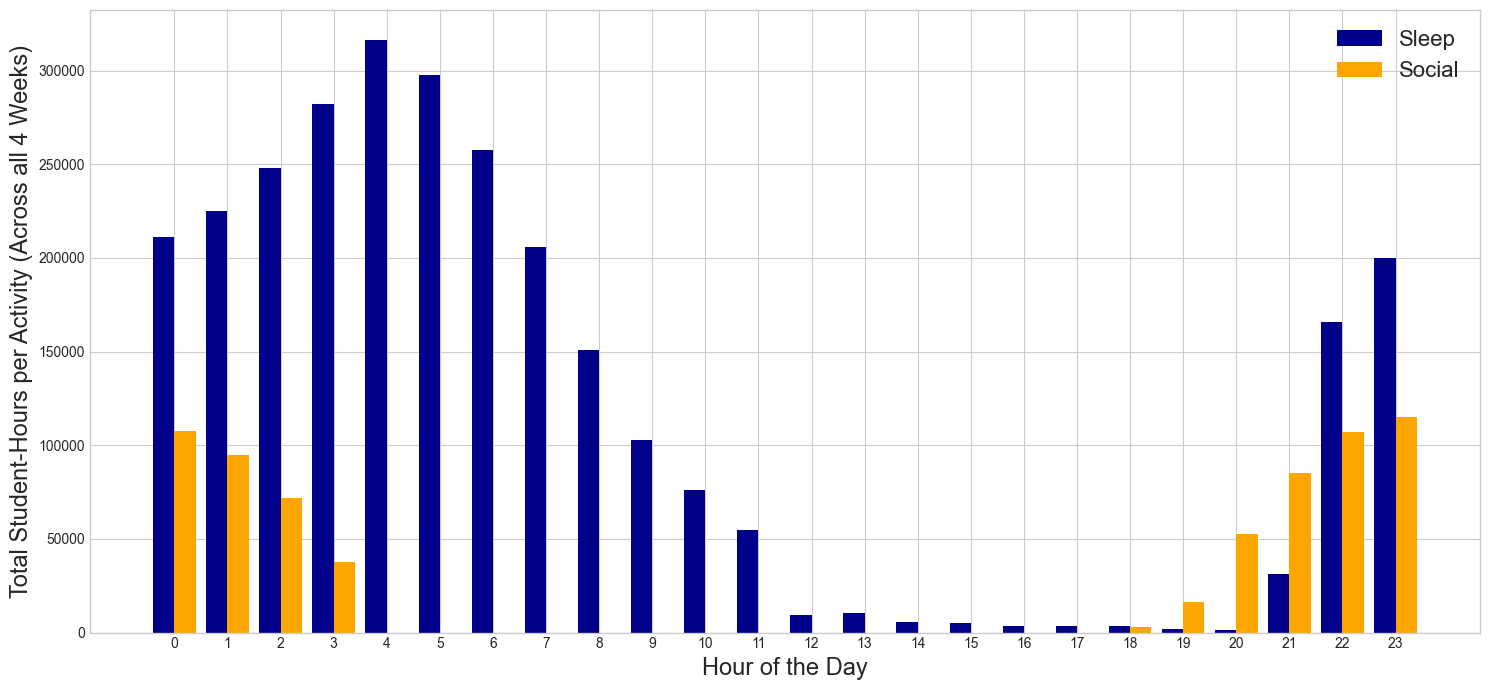


--- Analyzing Intra-Group Sleep Schedule Correlation ---

**Intra-Group Sleep Correlation Results:**
  - Average Standard Deviation of Bedtimes within a Group: 0.49 hours
  - Interpretation: LOW value, strong intra-group correlation.

--- Analyzing Group Social Sharing ---
  - Mean fraction of group social hours shared with at least one other group member: 22.17%
  - Median: 21.77%
  - 10th/90th percentiles: 17.91% / 27.23%


In [93]:
analyze_final_schedules('students_social_sleep_filled.csv')

Lecture hours per student (mean, min, max): 32.44965384278328 9 56
Canteen hours per student (mean, min, max): 34.30172640434668 11 51
Sleep hours per student (mean, min, max): 251.4293225834721 208 331
Social hours per student (mean, min, max): 60.48102707913417 30 118


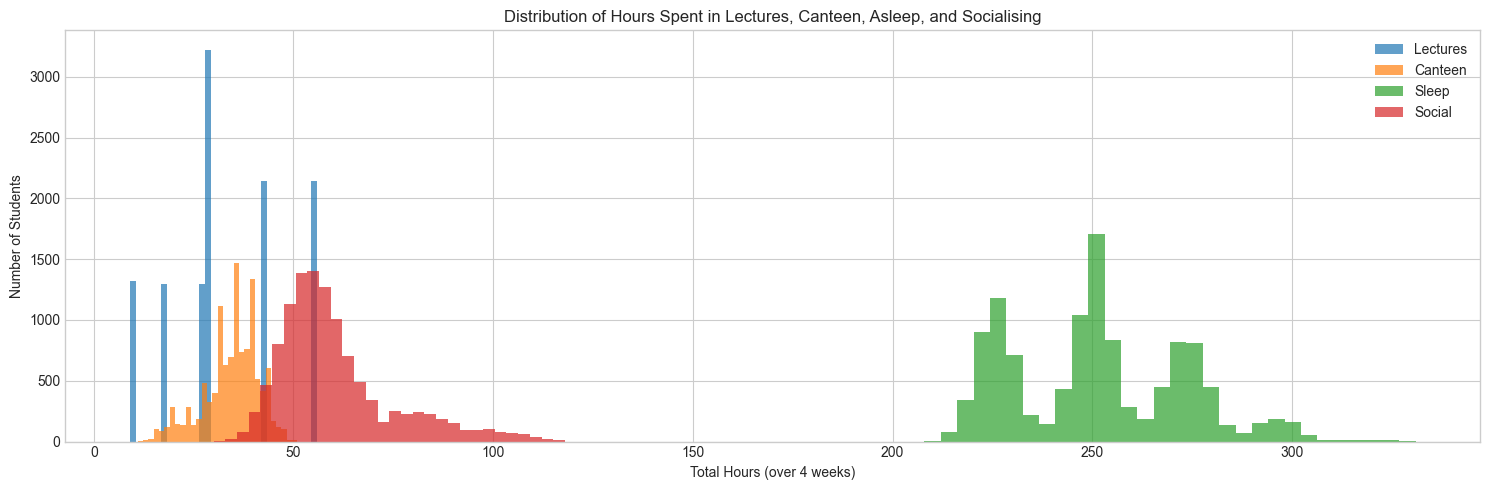

In [94]:

df = pd.read_csv('students_social_sleep_filled.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Count hours for each activity per student
def count_activity(row, keyword):
    return sum(keyword in str(val) for val in row[time_cols])

df['LectureHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Lecture'), axis=1)
df['CanteenHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Canteen'), axis=1)
df['SleepHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Sleep'), axis=1)
df['SocialHours'] = df[time_cols].apply(lambda row: count_activity(row, 'Social'), axis=1)

# Print summary statistics
print("Lecture hours per student (mean, min, max):", df['LectureHours'].mean(), df['LectureHours'].min(), df['LectureHours'].max())
print("Canteen hours per student (mean, min, max):", df['CanteenHours'].mean(), df['CanteenHours'].min(), df['CanteenHours'].max())
print("Sleep hours per student (mean, min, max):", df['SleepHours'].mean(), df['SleepHours'].min(), df['SleepHours'].max())
print("Social hours per student (mean, min, max):", df['SocialHours'].mean(), df['SocialHours'].min(), df['SocialHours'].max())

# Plot distributions
plt.figure(figsize=(15,5))
plt.hist(df['LectureHours'], bins=30, alpha=0.7, label='Lectures')
plt.hist(df['CanteenHours'], bins=30, alpha=0.7, label='Canteen')
plt.hist(df['SleepHours'], bins=30, alpha=0.7, label='Sleep')
plt.hist(df['SocialHours'], bins=30, alpha=0.7, label='Social')
plt.xlabel('Total Hours (over 4 weeks)')
plt.ylabel('Number of Students')
plt.title('Distribution of Hours Spent in Lectures, Canteen, Asleep, and Socialising')
plt.legend()
plt.tight_layout()
plt.show()

I now have a database of all 11000 students academic and culinary and social timings timetables for the first 4 weeks of the academic year.
We now have lectures, canteens, socials and sleep planned throughout the week. This just leaves 3 final 'types' to allocate - Outdoors, library and supermarket. <br>
Each student goes to the shops 1-3 times a week (normally distributed)<br>
The remaining 'Free' time of a student should be allocated to 20% 'Alone (Admin)' with a 5-40% of the remaining time being spent 'Outdoors' exercising, and then the rest of the time being spent in the 'Library'

In [95]:

df = pd.read_csv('students_social_sleep_filled.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]
schedule_arr = df[time_cols].values
n_students, n_hours = schedule_arr.shape

np.random.seed(42)

for idx in tqdm(range(n_students), desc="Allocating study and outdoor blocks"):
    # --- Study allocation ---
    study_left = int(round(df.at[idx, 'StudyBudget'])) if 'StudyBudget' in df.columns else 0
    study_blocks = []
    while study_left > 0:
        block = int(np.clip(np.random.normal(2, 0.7), 1, 4))
        block = min(block, study_left)
        study_blocks.append(block)
        study_left -= block

    # --- Outdoor allocation ---
    outdoor_left = int(round(df.at[idx, 'OutdoorBudget'])) if 'OutdoorBudget' in df.columns else 0
    outdoor_blocks = []
    while outdoor_left > 0:
        block = int(np.clip(np.random.normal(2, 0.7), 1, 3))
        block = min(block, outdoor_left)
        outdoor_blocks.append(block)
        outdoor_left -= block

    # --- Allocate study blocks into 'Free' slots ---
    free_indices = np.where(schedule_arr[idx] == 'Free')[0]
    np.random.shuffle(free_indices)
    ptr = 0
    for block in study_blocks:
        # Find next block of consecutive free slots
        while ptr < len(free_indices):
            start = free_indices[ptr]
            # Check if enough consecutive free slots
            if all((start + i) in free_indices for i in range(block)):
                schedule_arr[idx, [start + i for i in range(block)]] = 'Library'
                ptr += block
                break
            ptr += 1

    # --- Update free indices and allocate outdoor blocks ---
    free_indices = np.where(schedule_arr[idx] == 'Free')[0]
    np.random.shuffle(free_indices)
    ptr = 0
    for block in outdoor_blocks:
        while ptr < len(free_indices):
            start = free_indices[ptr]
            if all((start + i) in free_indices for i in range(block)):
                schedule_arr[idx, [start + i for i in range(block)]] = 'Outdoors'
                ptr += block
                break
            ptr += 1

# Assign back to DataFrame and save
df[time_cols] = schedule_arr
df.to_csv('students_social_sleep_study_outdoor_filled.csv', index=False)
print("Study and outdoor blocks allocated and saved to students_social_sleep_study_outdoor_filled.csv")

Allocating study and outdoor blocks:   0%|          | 0/11411 [00:00<?, ?it/s]

Study and outdoor blocks allocated and saved to students_social_sleep_study_outdoor_filled.csv


In [96]:
df = pd.read_csv('students_social_sleep_study_outdoor_filled.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]
schedule_arr = df[time_cols].values
n_students, n_hours = schedule_arr.shape

np.random.seed(42)

for idx in tqdm(range(n_students), desc="Allocating supermarket trips"):
    for week in range(4):
        # 2-3 trips per week, random integer
        n_trips = np.random.randint(2, 4)
        week_start = week * 7 * 24
        week_end = week_start + 7 * 24
        # Find all 'Free' slots between 8am and 10pm in this week
        possible_hours = [
            h for h in range(week_start, week_end)
            if schedule_arr[idx, h] == 'Free' and 8 <= (h % 24) < 22
        ]
        if len(possible_hours) >= n_trips:
            chosen = np.random.choice(possible_hours, n_trips, replace=False)
        else:
            chosen = possible_hours  # If not enough, use all available
        for h in chosen:
            schedule_arr[idx, h] = 'Supermarket'

# Assign back to DataFrame and save
df[time_cols] = schedule_arr

for col in time_cols:
    df[col] = df[col].replace('Free', 'Other')

df.to_csv('student_timetable_blocks_allocated.csv', index=False)
print("Supermarket trips allocated and saved to student_timetable_blocks_allocated.csv")

Allocating supermarket trips:   0%|          | 0/11411 [00:00<?, ?it/s]

Supermarket trips allocated and saved to student_timetable_blocks_allocated.csv


In [99]:
def analyze_final_schedules(input_filename): 
    """
    Analyzes the final schedules for all activity distributions and
    investigates the correlation between group membership and sleep patterns,
    and group social sharing.
    """
    print(f"--- Loading final schedules from '{input_filename}' ---")
    try:
        df = pd.read_csv(input_filename)
        df['Group ID'] = pd.to_numeric(df['Group ID'], errors='coerce')
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Could not find '{input_filename}'. Please ensure the previous script has run successfully.")
        return

    time_slot_cols = [f'T_{i}' for i in range(672)]
    groups = df.groupby('Group ID').groups

    # --- 1. Analyze and Visualize All Activity Distributions ---
    print("\n--- Analyzing Distribution of All Activities per Hour ---")
    # Prepare long-form DataFrame for plotting
    schedule_long = df[time_slot_cols].unstack().reset_index()
    schedule_long.columns = ['TimeSlot', 'StudentIndex', 'Activity']
    schedule_long['HourOfDay'] = schedule_long['TimeSlot'].str.replace('T_', '').astype(int) % 24

    # Map all lecture/canteen variants to 'Lectures'/'Canteen'
    def canonical_activity(act):
        act = str(act)
        if 'lecture' in act.lower():
            return 'Lectures'
        if 'canteen' in act.lower():
            return 'Canteen'
        return act

    schedule_long['ActivityGroup'] = schedule_long['Activity'].map(canonical_activity)

    # Order for plotting
    activity_order = [
        'Sleep', 'Lectures', 'Canteen', 'Supermarket', 'Other', 
        'Outdoors', 'Library', 'Social'
    ]
    # Add any missing activities to the order
    all_activities = pd.unique(schedule_long['ActivityGroup'])
    for act in all_activities:
        if act not in activity_order:
            activity_order.append(act)

    # Count occurrences of each activity per hour
    activity_counts = schedule_long.groupby(['HourOfDay', 'ActivityGroup']).size().unstack(fill_value=0)
    activity_counts = activity_counts[activity_order].fillna(0)

    # Plot stacked bar chart
    plt.figure(figsize=(18, 8))
    bottom = np.zeros(24)
    colors = {
        'Sleep': '#1f77b4', 'Lectures': '#ff7f0e', 'Canteen': '#2ca02c', 'Supermarket': '#9467bd',
        'Other': '#8c564b', 'Outdoors': '#17becf', 'Library': '#d62728', 'Social': '#e377c2'
    }
    for activity in activity_order:
        if activity in activity_counts:
            plt.bar(
                activity_counts.index, 
                activity_counts[activity], 
                bottom=bottom, 
                label=activity, 
                color=colors.get(activity, None), 
                width=0.95
            )
            bottom += activity_counts[activity].values

    plt.xlabel('Hour of the Day')
    plt.ylabel('Total Student-Hours (All 4 Weeks)')
    plt.title('Distribution of All Activities Over a 24-Hour Period')
    plt.xticks(np.arange(24))
    plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
    plt.tight_layout()
    plt.savefig('all_activity_distribution.png')
    print("Saved plot to all_activity_distribution.png")
    plt.show()


--- Loading final schedules from 'student_timetable_blocks_allocated.csv' ---
File loaded successfully.

--- Analyzing Distribution of All Activities per Hour ---
Saved plot to all_activity_distribution.png


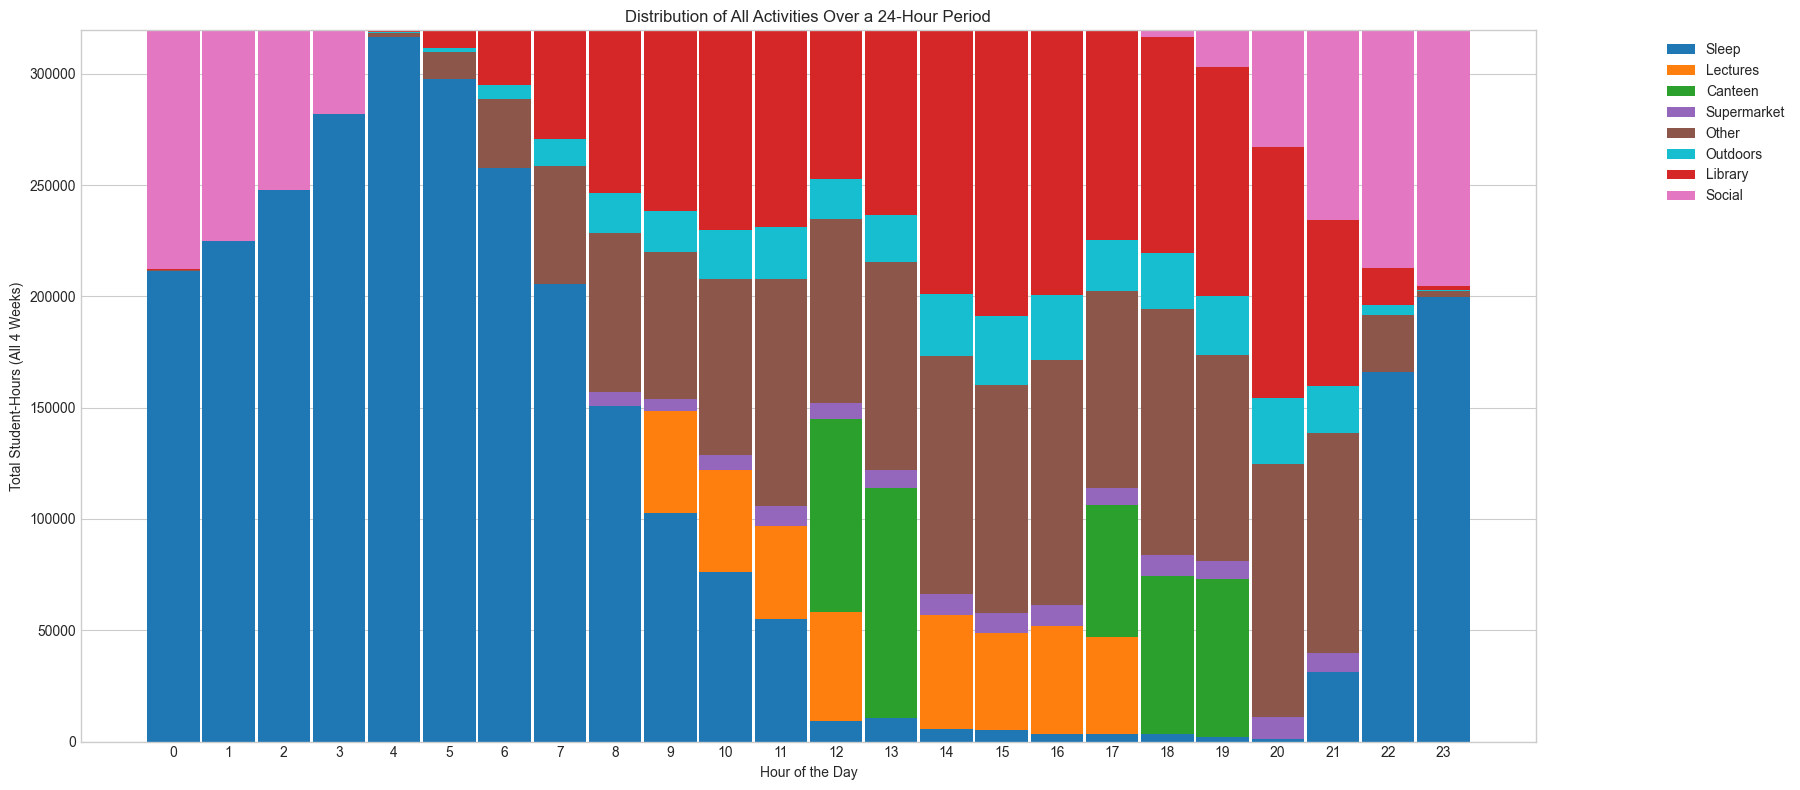

In [98]:
analyze_final_schedules('student_timetable_blocks_allocated.csv')

In [106]:
def analyze_schedule_week3_mon_fri(input_filename):
    """
    Analyze activity distributions for Monday-Friday of week 3 (hours 336 to 455).
    Prints summary and plots stacked bar chart of activities by hour of day.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    df = pd.read_csv(input_filename)
    time_cols = [f'T_{i}' for i in range(336, 456)]  # Week 3, Mon 00:00 to Fri 23:00 (5*24=120 hours)
    if not all(col in df.columns for col in time_cols):
        print("Some required time columns are missing.")
        return

    # Prepare long-form DataFrame for plotting
    schedule_long = df[time_cols].unstack().reset_index()
    schedule_long.columns = ['TimeSlot', 'StudentIndex', 'Activity']
    schedule_long['HourOfDay'] = schedule_long['TimeSlot'].str.replace('T_', '').astype(int) % 24

    # Canonicalize activity names
    def canonical_activity(act):
        act = str(act)
        if 'lecture' in act.lower():
            return 'Lectures'
        if 'canteen' in act.lower():
            return 'Canteen'
        return act

    schedule_long['ActivityGroup'] = schedule_long['Activity'].map(canonical_activity)

    # Order for plotting
    activity_order = [
        'Sleep', 'Lectures', 'Canteen', 'Supermarket', 'Other', 
        'Outdoors', 'Library', 'Social'
    ]
    all_activities = pd.unique(schedule_long['ActivityGroup'])
    for act in all_activities:
        if act not in activity_order:
            activity_order.append(act)

    # Count occurrences of each activity per hour
    activity_counts = schedule_long.groupby(['HourOfDay', 'ActivityGroup']).size().unstack(fill_value=0)
    activity_counts = activity_counts[activity_order].fillna(0)

    # Print summary
    print("Summary of total hours per activity (Mon-Fri, Week 3):")
    print(activity_counts.sum().astype(int))

    # Plot stacked bar chart
    plt.figure(figsize=(16, 7))
    bottom = np.zeros(24)
    colors = {
        'Sleep': '#1f77b4', 'Lectures': '#ff7f0e', 'Canteen': '#2ca02c', 'Supermarket': '#9467bd',
        'Other': '#8c564b', 'Outdoors': '#17becf', 'Library': '#d62728', 'Social': '#e377c2'
    }
    for activity in activity_order:
        if activity in activity_counts:
            plt.bar(
                activity_counts.index, 
                activity_counts[activity], 
                bottom=bottom, 
                label=activity, 
                color=colors.get(activity, None), 
                width=0.95
            )
            bottom += activity_counts[activity].values

    plt.xlabel('Hour of the Day', fontsize=17)
    plt.ylabel('Total Student-Hours (Mon-Fri, Week 3)', fontsize=17)
    #plt.title('Activity Distribution by Hour (Mon-Fri, Week 3)')
    plt.xticks(np.arange(24))
    plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1), fontsize=20)
    plt.tight_layout()
    plt.show()

# Example usage:


Summary of total hours per activity (Mon-Fri, Week 3):
ActivityGroup
Sleep          495262
Lectures       101350
Canteen         68164
Supermarket     20351
Other          260207
Outdoors        62187
Library        240175
Social         121624
dtype: int64


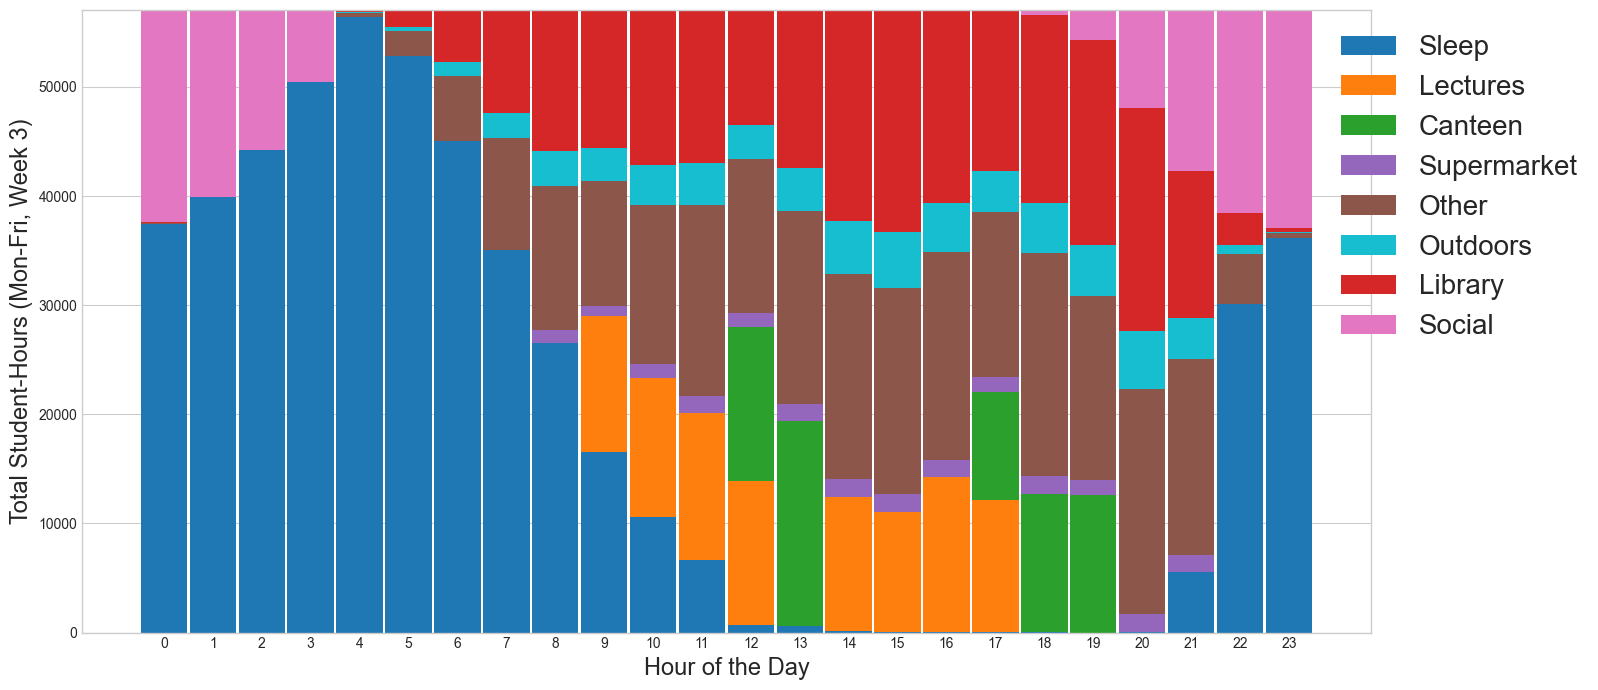

In [107]:
analyze_schedule_week3_mon_fri('student_timetable_blocks_allocated.csv')

So now the day has been allocated into types - which is excellent. Now students must be assigned to locations. It is assumed that during a block activity the student does not move <br>
So far there are types: 'Sleep', 'Social', 'Canteen', '___ Lectures', 'Supermarket', 'Alone (Admin)', 'Outdoors' and 'Library'. '___ Lectures', 'Alone (Admin)', 'Sleep'  and 'Outdoors' will remain unchanged for now. In 'Location_location.csv' there is a list of 220 locations with their geographic location (see headers). Only 'Social', 'Canteen', 'Supermarket' and 'Library' will be updated to real world locations stored within this csv file. <br>
'Supermarket' is the easiest to distribute. There are 8 'Supermarket' in the csv - See Location Type column to find them. 80% of the time a student will pick to go to 'Sainsbury's (Sidney Street)' unless they are at Girton or Homerton Colleges. The other 20% of the time, the student chooses to go to the supermarket that is closest to their college. <Br>
'Canteen' - The student chooses the canteen closest to their Subject building format = {'Subject' & 'Lectures'} 50% of the time if their previous location was '___ 'Lectures'' else they go to their college canteen. If they were not at lectures, 90% of the time they eat in their college canteen, with 10% of the time going to a random canteen within 2km from the student. <br>
'Library' - there are 3 categories here, subject, college and university. Only 3rd and 4th years go to the 'University Library' - and only 10% of them ever do, but they spend all their library time from 9am to 19pm there, else they go to their college library. Some students prefer to go to their college library, and others to their subject library - either way, a student will go to the same library 90% of the time. There is assumed to be no students who go to other college's or subject's  libaries.<br>
We will leave the social allocation for now as it is more complicated and requires futher thought. <br>
For now, code up seperate cell's for each location specifying algorithm. Saving a new csv file, then opening it for the next one each time. <br>


In [109]:
# Supermarket allocation
df = pd.read_csv('student_timetable_blocks_allocated.csv')
locations = pd.read_csv('Location_location.csv')

# Get supermarket locations
supermarkets = locations[locations['Location Type'].str.lower() == 'supermarket']
supermarket_names = supermarkets['Name'].tolist()

# Map college to closest supermarket (excluding Sainsbury's (Sidney Street))
college_coords = locations[locations['Location Type'].str.lower() == 'college'][['Name', 'Latitude', 'Longitude']]
supermarket_coords = supermarkets[['Name', 'Latitude', 'Longitude']]

def closest_supermarket(college):
    c_row = college_coords[college_coords['Name'] == college]
    if c_row.empty:
        return "Sainsbury's (Sidney Street)"
    c_lat, c_lon = c_row.iloc[0][['Latitude', 'Longitude']]
    dists = ((supermarket_coords['Latitude'] - c_lat)**2 + (supermarket_coords['Longitude'] - c_lon)**2)
    # Use .loc with dists.idxmin() to avoid index mismatch
    return supermarket_coords.loc[dists.idxmin(), 'Name']

time_cols = [col for col in df.columns if col.startswith('T_')]
college_lookup = df['College'] if 'College' in df.columns else pd.read_csv('students_groups_social.csv')['College']

for idx, row in df.iterrows():
    college = college_lookup.iloc[idx]
    for col in time_cols:
        if row[col] == 'Supermarket':
            if college in ['Girton', 'Homerton']:
                # Always go to their nearest supermarket
                df.at[idx, col] = closest_supermarket(college)
            else:
                if np.random.rand() < 0.8:
                    df.at[idx, col] = "Sainsbury's (Sidney Street)"
                else:
                    df.at[idx, col] = closest_supermarket(college)

df.to_csv('students_full_timetable_supermarket.csv', index=False)
print("Supermarket locations assigned and saved to students_full_timetable_supermarket.csv")

Supermarket locations assigned and saved to students_full_timetable_supermarket.csv


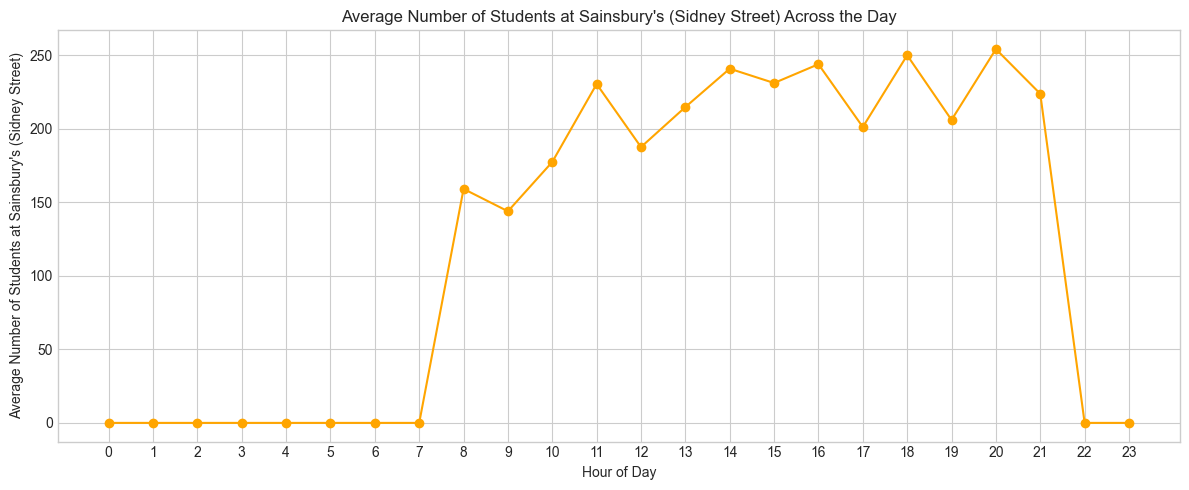

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the timetable with supermarket locations
df = pd.read_csv('students_full_timetable_supermarket.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Count number of students at Sainsbury's (Sidney Street) for each hour of the week (672 hours)
sainsburys_name = "Sainsbury's (Sidney Street)"
hours_per_day = 24
days = 7
weeks = df[time_cols].shape[1] // (hours_per_day * days)

# Sum over all weeks for each hour of the day
sainsburys_counts = np.zeros(hours_per_day, dtype=int)
total_days = weeks * days

for h in range(df[time_cols].shape[1]):
    hour_of_day = h % hours_per_day
    vals = df[time_cols[h]].values
    sainsburys_counts[hour_of_day] += np.sum(vals == sainsburys_name)

# Average over all days
sainsburys_avg = sainsburys_counts / total_days

plt.figure(figsize=(12, 5))
plt.plot(np.arange(hours_per_day), sainsburys_avg, marker='o', color='orange')
plt.xticks(np.arange(hours_per_day))
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Students at Sainsbury\'s (Sidney Street)')
plt.title('Average Number of Students at Sainsbury\'s (Sidney Street) Across the Day')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [134]:
# Efficient canteen assignment with group lunch coordination

df = pd.read_csv('students_full_timetable_supermarket.csv')
locations = pd.read_csv('Location_location.csv')
canteens = locations[locations['Location Type'].str.lower() == 'canteen'].reset_index(drop=True)
students = pd.read_csv('students_groups_social.csv')

time_cols = [col for col in df.columns if col.startswith('T_')]
subject_lookup = students['Subject'].values
college_lookup = students['College'].values
group_lookup = students['Group ID'].values

# Precompute college canteen names
college_canteen_map = {college: f"{college} Canteen" for college in np.unique(college_lookup)}

# Precompute subject building coordinates for all subjects
subject_building_coords = {}
for subject in np.unique(subject_lookup):
    matches = locations[locations['Name'].str.contains(fr'\b{re.escape(subject)}\b', case=False, na=False, regex=True)]
    if not matches.empty:
        subject_building_coords[subject] = tuple(matches.iloc[0][['Latitude', 'Longitude']])
    else:
        subject_building_coords[subject] = (np.nan, np.nan)

# Helper: find canteen closest to a given lat/lon
def closest_canteen(lat, lon):
    dists = ((canteens['Latitude'] - lat)**2 + (canteens['Longitude'] - lon)**2)
    return canteens.loc[dists.idxmin(), 'Name']

# Precompute college coordinates for random nearby canteen fallback
college_coords = locations[locations['Location Type'].str.lower() == 'college'].set_index('Name')[['Latitude', 'Longitude']]

# Build a mapping from group ID to student indices
group_to_indices = {}
for idx, gid in enumerate(group_lookup):
    if pd.notna(gid):
        group_to_indices.setdefault(gid, []).append(idx)

# Convert df[time_cols] to numpy array for fast access and assignment
canteen_arr = df[time_cols].values
n_students, n_hours = canteen_arr.shape

# Precompute group canteen choices for each time slot for efficiency
group_canteen_choices = [{} for _ in range(n_hours)]  # list of dicts: {group_id: [canteen_names]}

for t, col in enumerate(time_cols):
    # For each group, collect canteen choices at this time
    group_canteens = {}
    for gid, indices in group_to_indices.items():
        vals = canteen_arr[indices, t]
        canteens_here = [v for v in vals if isinstance(v, str) and 'canteen' in v.lower()]
        if canteens_here:
            group_canteens[gid] = canteens_here
    group_canteen_choices[t] = group_canteens

for idx in range(n_students):
    college = college_lookup[idx]
    subject = subject_lookup[idx]
    group_id = group_lookup[idx]
    subj_lat, subj_lon = subject_building_coords.get(subject, (np.nan, np.nan))
    college_canteen = college_canteen_map.get(college, f"{college} Canteen")
    # Get college coordinates for fallback
    if college in college_coords.index:
        c_lat, c_lon = college_coords.loc[college]
    else:
        c_lat, c_lon = np.nan, np.nan

    for t, col in enumerate(time_cols):
        if canteen_arr[idx, t] == 'Canteen':
            prev = canteen_arr[idx, t-1] if t > 0 else ''
            hour = t % 24
            # --- Group lunch/dinner coordination (efficient) ---
            group_canteens = group_canteen_choices[t].get(group_id, [])
            if group_canteens and np.random.rand() < 0.7:
                canteen_arr[idx, t] = np.random.choice(group_canteens)
                continue
            # --- Lunch (11:00-15:00) or Dinner (17:00-20:00) logic ---
            if (11 <= hour < 15) or (17 <= hour < 20):
                if isinstance(prev, str) and 'lecture' in prev.lower():
                    # 50% subject canteen, 50% college canteen
                    if np.random.rand() < 0.5 and not np.isnan(subj_lat):
                        canteen_arr[idx, t] = closest_canteen(subj_lat, subj_lon)
                    else:
                        canteen_arr[idx, t] = college_canteen
                else:
                    # 95% college canteen, 5% random nearby canteen
                    if np.random.rand() < 0.95:
                        canteen_arr[idx, t] = college_canteen
                    else:
                        if not np.isnan(c_lat):
                            dists = np.sqrt((canteens['Latitude'] - c_lat)**2 + (canteens['Longitude'] - c_lon)**2)
                            nearby = canteens[dists < 0.018]
                            if not nearby.empty:
                                canteen_arr[idx, t] = np.random.choice(nearby['Name'])
                            else:
                                canteen_arr[idx, t] = college_canteen
                        else:
                            canteen_arr[idx, t] = college_canteen
            else:
                # Outside lunch/dinner, default to college canteen
                canteen_arr[idx, t] = college_canteen

# Assign back to DataFrame and save
df[time_cols] = canteen_arr
df.to_csv('students_full_timetable_canteen.csv', index=False)
print("Canteen locations assigned (with group coordination, efficient) and saved to students_full_timetable_canteen.csv")

Canteen locations assigned (with group coordination, efficient) and saved to students_full_timetable_canteen.csv


In [135]:
# LIBRARY & CAFE ASSIGNMENT (updated for cafe allocation)
df = pd.read_csv('students_full_timetable_canteen.csv')
locations = pd.read_csv('Location_location.csv')
libraries = locations[locations['Location Type'].str.lower().str.contains('library')]
cafes = locations[locations['Location Type'].str.lower() == 'caff']
students = pd.read_csv('students_groups_social.csv')

time_cols = [col for col in df.columns if col.startswith('T_')]
year_lookup = students['Year'].values
college_lookup = students['College'].values
subject_lookup = students['Subject'].values

# Precompute subject library mapping for fast lookup (only for hours 8 <= h < 18)
subject_library_map = {}
for subject in np.unique(subject_lookup):
    subj_lib = libraries[libraries['Name'].str.contains(fr'\b{re.escape(subject)}\b', case=False, na=False, regex=True)]
    if not subj_lib.empty:
        subject_library_map[subject] = subj_lib.iloc[0]['Name']
    else:
        subject_library_map[subject] = None

# Assign a "room worker" percentage to each student (mean 10%, clipped 0-100%)
np.random.seed(42)
room_worker_pct = np.clip(np.random.normal(0.10, 0.05, len(df)), 0, 1)

# Precompute per-student library preferences for efficiency
prefer_college_arr = np.random.rand(len(df)) < 0.5
use_univ_arr = np.array([(year in [3, 4]) and (np.random.rand() < 0.1) for year in year_lookup])

# Precompute 20% cafe users
use_cafe_arr = np.random.rand(len(df)) < 0.2

# Precompute 3 nearest cafes for each college
college_coords = locations[locations['Location Type'].str.lower() == 'college'][['Name', 'Latitude', 'Longitude']]
cafe_coords = cafes[['Name', 'Latitude', 'Longitude']]
nearest_cafes_map = {}
for college in college_coords['Name']:
    c_row = college_coords[college_coords['Name'] == college]
    c_lat, c_lon = c_row.iloc[0][['Latitude', 'Longitude']]
    cafes_sorted = cafe_coords.copy()
    cafes_sorted['dist'] = ((cafes_sorted['Latitude'] - c_lat)**2 + (cafes_sorted['Longitude'] - c_lon)**2)
    nearest_cafes_map[college] = cafes_sorted.nsmallest(3, 'dist')['Name'].tolist()

import time
start_time = time.time()
slots_allocated = 0

for idx, row in df.iterrows():
    year = year_lookup[idx]
    college = college_lookup[idx]
    subject = subject_lookup[idx]
    prefer_college = prefer_college_arr[idx]
    use_univ = use_univ_arr[idx]
    subj_lib_name = subject_library_map.get(subject, None)
    room_pct = room_worker_pct[idx]
    use_cafe = use_cafe_arr[idx]
    # Find all library slots for this student (for possible cafe allocation)
    lib_slots = [t for t, col in enumerate(time_cols) if row[col] == 'Library']
    cafe_slots = []
    if use_cafe and len(lib_slots) > 0:
        # Only consider slots between 9 and 17 (inclusive)
        day_hours = [t for t in lib_slots if 9 <= (t % 24) < 17]
        n_cafe = int(np.round(0.5 * len(day_hours)))
        if n_cafe > 0:
            cafe_slots = np.random.choice(day_hours, n_cafe, replace=False)
    for t, col in enumerate(time_cols):
        if row[col] == 'Library':
            hour = t % 24
            if t in cafe_slots:
                # Assign to one of the 3 nearest cafes
                cafe_name = np.random.choice(nearest_cafes_map.get(college, cafes['Name'].tolist()))
                df.at[idx, col] = cafe_name
            # After 18:00 or before 8:00, only college library or room work
            elif hour < 8 or hour >= 18:
                if np.random.rand() < room_pct:
                    df.at[idx, col] = 'Own Room'
                else:
                    df.at[idx, col] = f"{college} Library"
            # University Library for 3rd/4th years, 9am-7pm, 10% chance
            elif use_univ and 9 <= hour < 19:
                df.at[idx, col] = 'University Library'
            # Subject library only 8:00-17:59, if not a room worker and not prefer_college
            elif subj_lib_name is not None and not prefer_college and np.random.rand() > room_pct:
                df.at[idx, col] = subj_lib_name
            # Otherwise, college library or room
            else:
                if np.random.rand() < room_pct:
                    df.at[idx, col] = 'Own Room'
                else:
                    df.at[idx, col] = f"{college} Library"
            slots_allocated += 1
            if slots_allocated % 100000 == 0:
                elapsed = time.time() - start_time
                print(f"{slots_allocated} library/cafe slots allocated in {elapsed:.1f} seconds...")

elapsed = time.time() - start_time
print(f"Library and cafe locations assigned and saved to students_full_timetable_library.csv")
print(f"Total slots allocated: {slots_allocated} in {elapsed:.1f} seconds")

df.to_csv('students_full_timetable_library.csv', index=False)

100000 library/cafe slots allocated in 3.6 seconds...
200000 library/cafe slots allocated in 7.1 seconds...
300000 library/cafe slots allocated in 10.3 seconds...
400000 library/cafe slots allocated in 13.4 seconds...
500000 library/cafe slots allocated in 16.7 seconds...
600000 library/cafe slots allocated in 19.8 seconds...
700000 library/cafe slots allocated in 23.0 seconds...
800000 library/cafe slots allocated in 26.2 seconds...
900000 library/cafe slots allocated in 29.4 seconds...
1000000 library/cafe slots allocated in 32.5 seconds...
1100000 library/cafe slots allocated in 35.7 seconds...
1200000 library/cafe slots allocated in 38.8 seconds...
1300000 library/cafe slots allocated in 41.9 seconds...
1400000 library/cafe slots allocated in 45.0 seconds...
Library and cafe locations assigned and saved to students_full_timetable_library.csv
Total slots allocated: 1430443 in 46.0 seconds


Ok so its only social locations to be allocated now.  <br>
There are 3 main social spaces. College bars, Pubs and Clubs. Check that you can load all the college bars, the pubs and the clubs {Done} <br>
How to allocate 'Social' blocks to locations. One thing is sure, all members of the group who are 'Social' in this hour should be in the same location. Socialising for the night generally (75%) starts in a college bar if you're a first year, or a pub if 2-4th year. If the social extends to 11pm and beyond, the group will move to a club. 30% of groups move to a Club at 11pm, the remainders at midnight. College bars 95% of the time will be the groups majority college bar, otherwise it will be a random nearby one. Pubs will randomly be one of the 5 nearest pubs to the college of the group. Critically, once a group has set up in a college bar or pub, they will not move until either they go to sleep or a club. The location distribution of the club is more complicated, and will be updated later - for now, just replace 'Social' with 'Club'.

In [157]:
# SOCIAL LOCATION PLACEMENT: GROUP-BASED, BLOCKWISE, WITH CLUB/ROOM POSTS LOGIC
df = pd.read_csv('students_full_timetable_library.csv')
locations = pd.read_csv('Location_location.csv')
students = pd.read_csv('students_groups_social.csv')

college_bars = locations[
    locations['Location Type'].str.lower().str.contains('bar') |
    locations['Name'].str.lower().str.contains('bar')
].reset_index(drop=True)
pubs = locations[
    locations['Location Type'].str.lower().str.contains('pub') |
    locations['Name'].str.lower().str.contains('pub')
].reset_index(drop=True)
clubs = locations[
    locations['Location Type'].str.lower().str.contains('club') |
    locations['Name'].str.lower().str.contains('club')
].reset_index(drop=True)

time_cols = [col for col in df.columns if col.startswith('T_')]
student_group = students['Group ID'].values
student_year = students['Year'].values
student_college = students['College'].values

# Map group ID to student indices
group_to_indices = {}
for idx, gid in enumerate(student_group):
    if pd.notna(gid):
        group_to_indices.setdefault(gid, []).append(idx)

# Map college to its bar (majority bar)
college_bar_map = {}
for college in np.unique(student_college):
    matches = college_bars[college_bars['Name'].str.lower().str.contains(college.lower())]
    college_bar_map[college] = matches.iloc[0]['Name'] if not matches.empty else np.random.choice(college_bars['Name'])

# Precompute nearest 5 pubs for each college
college_coords = locations[locations['Location Type'].str.lower() == 'college'][['Name', 'Latitude', 'Longitude']]
pub_coords = pubs[['Name', 'Latitude', 'Longitude']]
nearest_pubs_map = {}
for college in college_coords['Name']:
    c_row = college_coords[college_coords['Name'] == college]
    c_lat, c_lon = c_row.iloc[0][['Latitude', 'Longitude']]
    pubs_sorted = pub_coords.copy()
    pubs_sorted['dist'] = ((pubs_sorted['Latitude'] - c_lat)**2 + (pubs_sorted['Longitude'] - c_lon)**2)
    nearest_pubs_map[college] = pubs_sorted.nsmallest(5, 'dist')['Name'].tolist()

def pick_club(day_of_week):
    club_names = clubs['Name'].tolist()
    club_names_lower = [c.lower() for c in club_names]
    def find_club(substring):
        for i, name in enumerate(club_names_lower):
            if substring in name:
                return club_names[i]
        return None
    mash = find_club('mash') or np.random.choice(club_names)
    lola = find_club('lola') or np.random.choice(club_names)
    revs = find_club('rev') or np.random.choice(club_names)
    vinyl = find_club('vinyl') or np.random.choice(club_names)
    others = [c for c in club_names if c not in [mash, lola, revs, vinyl]]
    r = np.random.rand()
    if day_of_week == 4:  # Friday
        if r < 0.8: return mash
        else: return np.random.choice([lola, revs, vinyl] + others)
    elif day_of_week == 6:  # Sunday
        if r < 0.8: return lola
        else: return np.random.choice([mash, revs, vinyl] + others)
    elif day_of_week == 2:  # Wednesday
        if r < 0.9: return revs
        else: return np.random.choice([mash, lola, vinyl] + others)
    elif day_of_week == 3:  # Thursday
        if r < 0.5: return vinyl
        else: return np.random.choice([mash, lola, revs] + others)
    elif day_of_week in [0, 1, 5]:  # Mon, Tue, Sat
        if r < 0.3: return revs
        elif r < 0.6: return mash
        elif r < 0.9: return lola
        else: return vinyl
    else:
        return np.random.choice(club_names)

room_posts_name = "Room Posts"
schedule_arr = df[time_cols].values
n_students, n_hours = schedule_arr.shape

for gid, indices in tqdm(group_to_indices.items(), desc="Fast group social locations"):
    group_mask = np.zeros((len(indices), n_hours), dtype=bool)
    for i, idx in enumerate(indices):
        group_mask[i] = schedule_arr[idx] == 'Social'
    for t in range(n_hours):
        social_indices = [indices[i] for i in range(len(indices)) if group_mask[i, t]]
        if not social_indices:
            continue
        block_hour_of_day = t % 24
        day_of_week = (t // 24) % 7
        years = student_year[social_indices]
        colleges = student_college[social_indices]
        majority_year = int(np.round(np.median(years)))
        majority_college = pd.Series(colleges).mode()[0]
        # Decide location
        if len(social_indices) > 1:
            prev_locs = []
            if t > 0:
                for idx in social_indices:
                    prev_locs.append(schedule_arr[idx, t-1])
                prev_counts = pd.Series(prev_locs).value_counts()
                prev_main = prev_counts.index[0] if not prev_counts.empty else None
                prev_is_pubbarclub = prev_main in pubs['Name'].tolist() + college_bars['Name'].tolist() + clubs['Name'].tolist()
                prev_is_collegebar = prev_main in college_bars['Name'].tolist()
            else:
                prev_main = None
                prev_is_pubbarclub = False
                prev_is_collegebar = False
            # Force move at midnight if in college bar
            if prev_is_collegebar and (24 <= block_hour_of_day < 28) :
                # 40% pub, 40% club, 20% Room Posts
                r = np.random.rand()
                if r < 0.5:
                    pub_choices = nearest_pubs_map.get(majority_college, pubs['Name'].tolist())
                    loc = np.random.choice(pub_choices)
                elif r < 0.75:
                    loc = pick_club(day_of_week)
                else:
                    loc = room_posts_name
            # 23:00 or later: 50% club, 50% Room Posts
            elif block_hour_of_day >= 23:
                if np.random.rand() < 0.5:
                    loc = pick_club(day_of_week)
                else:
                    loc = room_posts_name
            # Stickiness: if previous location is pub/bar/club, stay with high probability
            elif prev_is_pubbarclub and np.random.rand() < 0.92:
                loc = prev_main
            elif majority_year == 1 and np.random.rand() < 0.75:
                loc = college_bar_map.get(majority_college, np.random.choice(college_bars['Name']))
                if np.random.rand() >= 0.95:
                    loc = np.random.choice(college_bars['Name'])
            else:
                if np.random.rand() < 0.2:
                    loc = college_bar_map.get(majority_college, np.random.choice(college_bars['Name']))
                else:
                    pub_choices = nearest_pubs_map.get(majority_college, pubs['Name'].tolist())
                    loc = np.random.choice(pub_choices)
            for idx in social_indices:
                schedule_arr[idx, t] = loc
        else:
            # Solo fallback
            college = student_college[social_indices[0]]
            bar_name = college_bar_map.get(majority_college, np.random.choice(college_bars['Name']))
            schedule_arr[social_indices[0], t] = bar_name

df[time_cols] = schedule_arr
df.to_csv('students_full_timetable_social.csv', index=False)
print("Social locations assigned (club/Room Posts split after 23:00, college bars shut at 0:00) and saved to students_full_timetable_social.csv")

Fast group social locations: 100%|██████████| 1837/1837 [01:10<00:00, 25.89it/s]


Social locations assigned (club/Room Posts split after 23:00, college bars shut at 0:00) and saved to students_full_timetable_social.csv


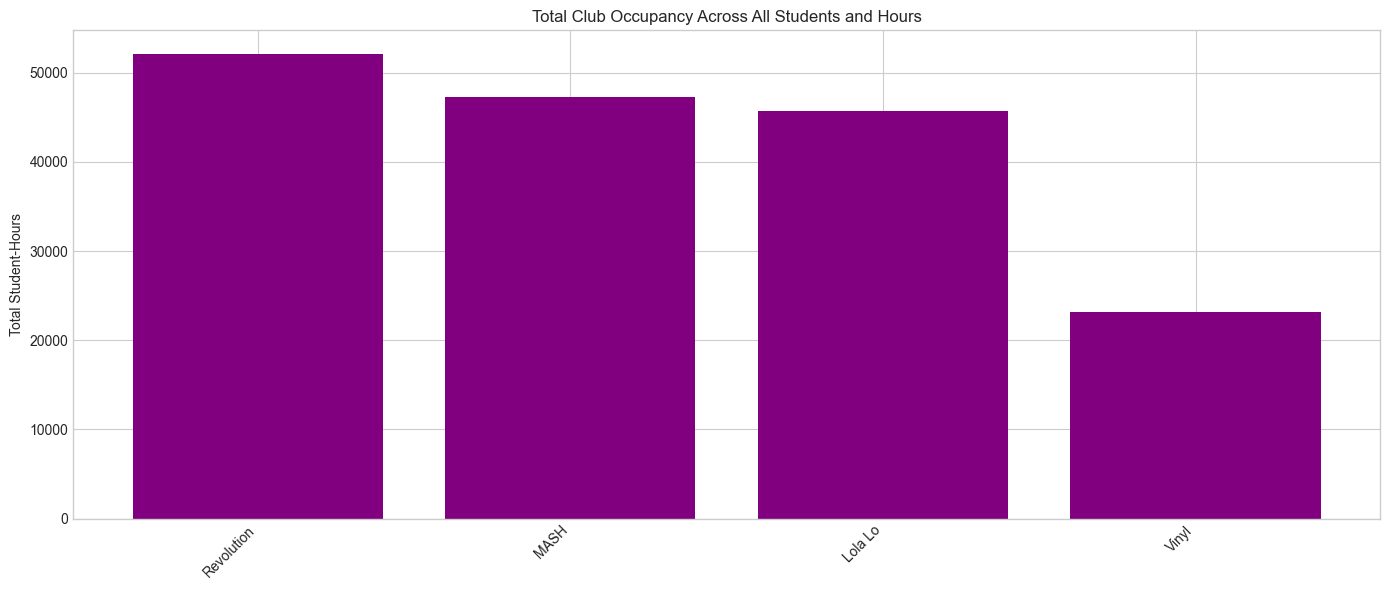

In [155]:

# Load the social timetable with club allocations
df = pd.read_csv('students_full_timetable_social.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Load club names from locations file
locations = pd.read_csv('Location_location.csv')
clubs = locations[
    locations['Location Type'].str.lower().str.contains('club') |
    locations['Name'].str.lower().str.contains('club')
].reset_index(drop=True)
club_names = clubs['Name'].tolist()

# Count club occupancies across all hours
club_counts = {club: 0 for club in club_names}
for col in time_cols:
    vals = df[col].value_counts()
    for club in club_names:
        club_counts[club] += vals.get(club, 0)

# Sort by occupancy
club_counts_sorted = dict(sorted(club_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(14, 6))
plt.bar(club_counts_sorted.keys(), club_counts_sorted.values(), color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Student-Hours')
plt.title('Total Club Occupancy Across All Students and Hours')
plt.tight_layout()
plt.show()

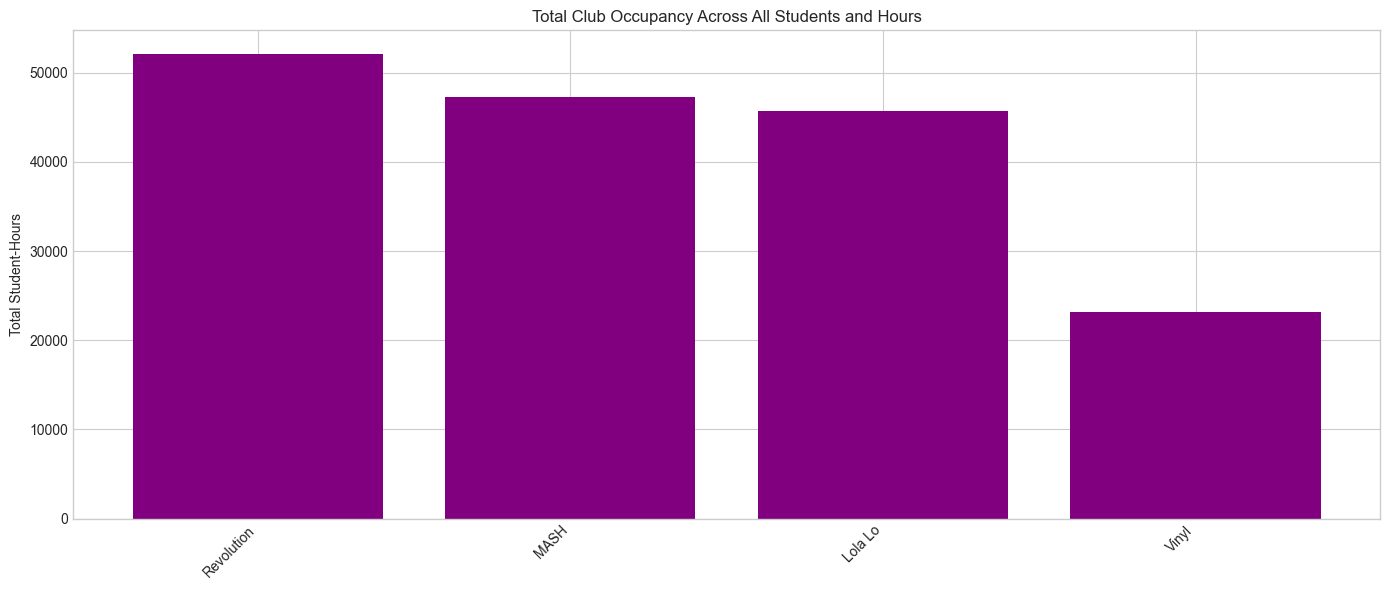

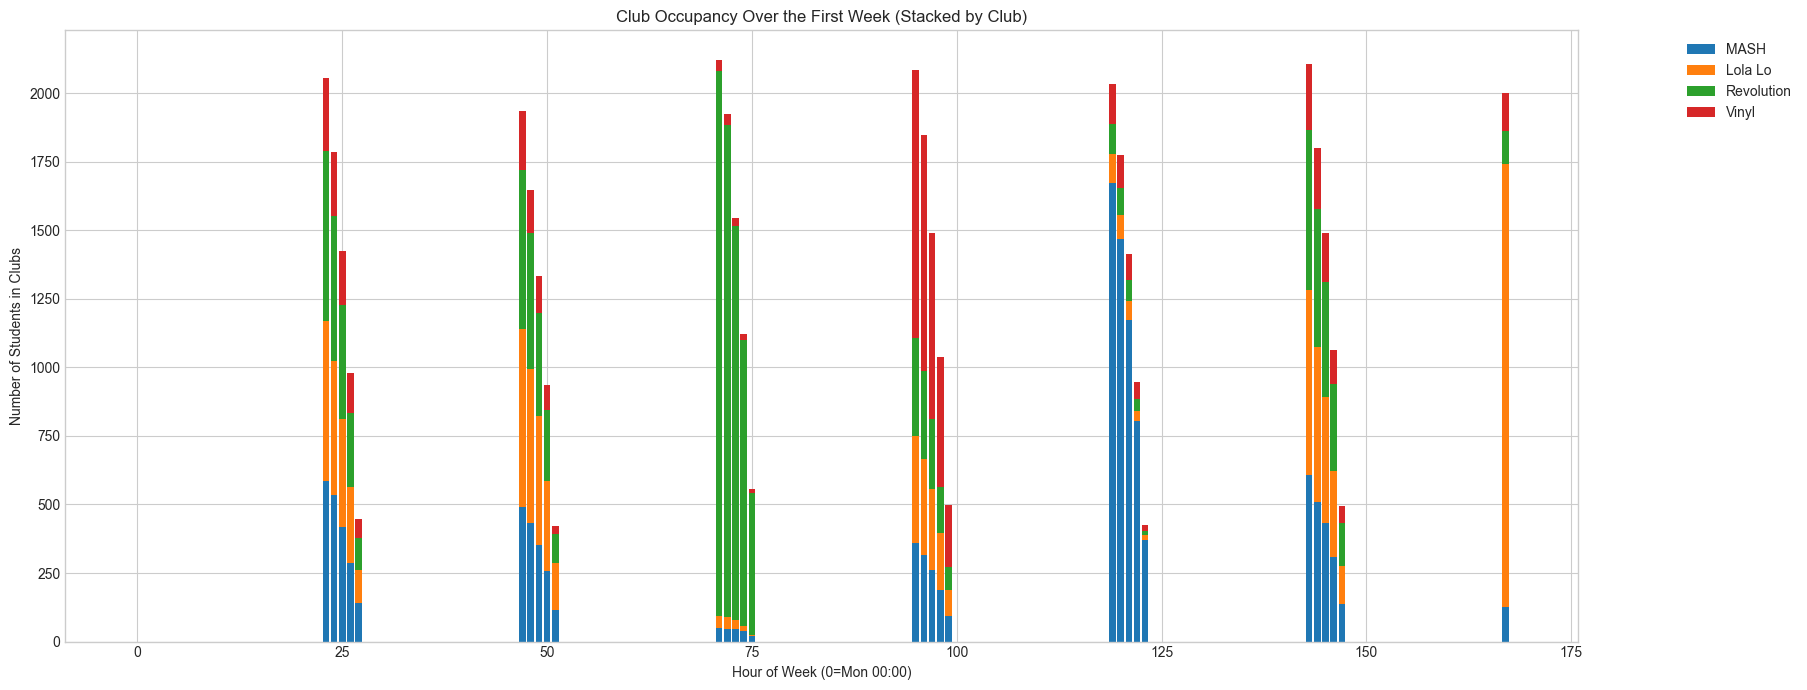

In [156]:
# Load the social timetable with club allocations
df = pd.read_csv('students_full_timetable_social.csv')
time_cols = [col for col in df.columns if col.startswith('T_')]

# Load club names from locations file
locations = pd.read_csv('Location_location.csv')
clubs = locations[
    locations['Location Type'].str.lower().str.contains('club') |
    locations['Name'].str.lower().str.contains('club')
].reset_index(drop=True)
club_names = clubs['Name'].tolist()

# --- Plot 1: Total club occupancy across all hours ---
club_counts = {club: 0 for club in club_names}
for col in time_cols:
    vals = df[col].value_counts()
    for club in club_names:
        club_counts[club] += vals.get(club, 0)

club_counts_sorted = dict(sorted(club_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 6))
plt.bar(club_counts_sorted.keys(), club_counts_sorted.values(), color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Student-Hours')
plt.title('Total Club Occupancy Across All Students and Hours')
plt.tight_layout()
plt.show()

# --- Plot 2: Club occupancy over a single week (168 hours) ---

# Pick the first week (hours 0 to 167)
week_cols = [f'T_{i}' for i in range(7*24)]
club_week_counts = {club: np.zeros(7*24, dtype=int) for club in club_names}

for h, col in enumerate(week_cols):
    vals = df[col].value_counts()
    for club in club_names:
        club_week_counts[club][h] = vals.get(club, 0)

# Plot as a stacked bar chart: x-axis is hour of week, y is number of students, stacked by club
plt.figure(figsize=(18, 7))
bottom = np.zeros(7*24)
for club in club_names:
    plt.bar(
        np.arange(7*24),
        club_week_counts[club],
        bottom=bottom,
        label=club
    )
    bottom += club_week_counts[club]

plt.xlabel('Hour of Week (0=Mon 00:00)')
plt.ylabel('Number of Students in Clubs')
plt.title('Club Occupancy Over the First Week (Stacked by Club)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

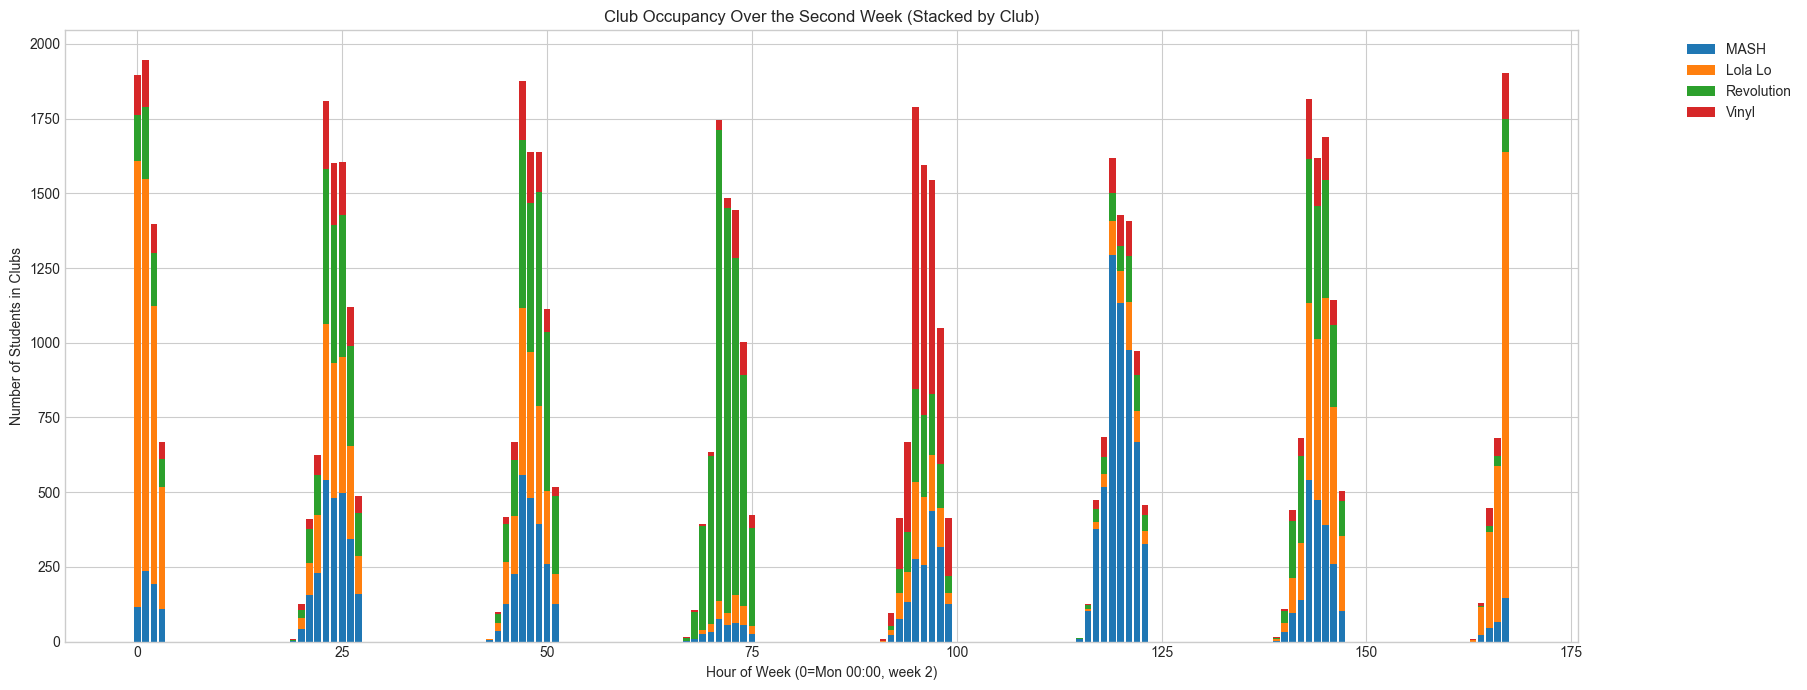

In [152]:
# --- Plot 2: Club occupancy over the SECOND week (hours 168 to 335) ---

# Pick the second week (hours 168 to 335)
week2_cols = [f'T_{i}' for i in range(7*24, 2*7*24)]
club_week2_counts = {club: np.zeros(7*24, dtype=int) for club in club_names}

for h, col in enumerate(week2_cols):
    vals = df[col].value_counts()
    for club in club_names:
        club_week2_counts[club][h] = vals.get(club, 0)

# Plot as a stacked bar chart: x-axis is hour of week, y is number of students, stacked by club
plt.figure(figsize=(18, 7))
bottom = np.zeros(7*24)
for club in club_names:
    plt.bar(
        np.arange(7*24),
        club_week2_counts[club],
        bottom=bottom,
        label=club
    )
    bottom += club_week2_counts[club]

plt.xlabel('Hour of Week (0=Mon 00:00, week 2)')
plt.ylabel('Number of Students in Clubs')
plt.title('Club Occupancy Over the Second Week (Stacked by Club)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [141]:
df.to_csv('ColocCotime_network_base.csv')

print("Saved timetable as ColocCotime_network_base.csv")

Saved timetable as ColocCotime_network_base.csv


We now have a complete set of mostly realistic schedules from which to generate a co-temporal, co-location disease spreading model.